Наша цель – востановить зависимость $ f: X \rightarrow Y $.
Востанавливать её будем по набдюдениям, приближая набором деревьев решений.

In [4]:
import sys
import numpy as np
import xgboost as xgb
# !{sys.executable} -m pip  install sklearn-evaluation
import matplotlib.pyplot as plt

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pwd

/home/acoustic/aponom


# Считываем $X$ #

## Готовим имена признаков ##

1) sk_le [dB/Hz] наклон слева, коэффициент при аппроксимации полином первой степени методом наименьших квадратов участка линии на Рис.1 в диапазоне [-1.75; -0.75] Гц, должен быть положительным.
2) sk_ri [dB/Hz] наклон справа, -"- в диапазоне [0.75; 1.75] Гц, -"- отрицательным
3) centr1 [Hz] средневзвешенное значение частоты
4) centr2 [Hz] среднемедианное значение частоты
5) lvl [dB] уровень сигнала
6) sk_le2[dB/Hz] - второй наклон слева в диапазоне [-3.2; -1.45] Гц
7) sk_ri2[dB/Hz] - второй наклон справа в диапазоне [1.45; 3.2;] Гц
8) lv_brag_le [dB] - уровень сигнала слева в диапазоне 1Гц вокруг частоты Брегга -2±0.5Гц 
9) lv_brag_ri[dB]- уровень сигнала справа в диапазоне +2±0.5Гц

In [5]:
times = [0.3355, 0.671, 1.07, 1.342, 1.678, 2.01, 2.35, 2.68]
# angles = list(range(-90, 100, 10))
angles = list(range(-90, 100, 30))
features = ['sk_le', 'sk_ri', 'centr1', 'centr2', 'lvl', 'sk_le2', 'sk_ri2', 'lv_brag_le', 'lv_brag_ri'] 
all_features = [] 
for feature in features:
    for angle in angles:
        for time in times:
            all_features.append(f'{feature} {angle} {time}')

## Пробегаемся по всем дням и всем файлам внутри дня и формируем список словарей list_dict ##

In [6]:
!ls /Users/polina/Downloads/2720Hz/features_dat/31

01_00_half1.dat 04_00_half1.dat 10_00_half2.dat 19_00_half1.dat 22_00_half1.dat
01_00_half2.dat 04_00_half2.dat 12_00_half2.dat 19_00_half2.dat 22_00_half2.dat
02_00_half1.dat 05_00_half1.dat 14_30_half1.dat 20_05_half1.dat 23_00_half1.dat
02_00_half2.dat 05_00_half2.dat 14_30_half2.dat 20_05_half2.dat 23_00_half2.dat
03_00_half1.dat 06_00_half1.dat 17_00_half1.dat 21_05_half1.dat 23_59_half1.dat
03_00_half2.dat 06_00_half2.dat 17_00_half2.dat 21_05_half2.dat 23_59_half2.dat


In [7]:
from datetime import datetime, timezone, timedelta

In [8]:
days = !ls /Users/polina/Downloads/2720Hz/features_dat
# days = !ls /home/acoustic/ddrazumov/2720Hz/features_dat
days

['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']

In [16]:
days

['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']

In [24]:
import pandas as pd
start_date = datetime(2021, 9 , 1)
def read_XY(freq):
    list_dict = []
    for day in days:
        folder_date = start_date + timedelta(days = int(day) -1 )
        folder = f'/Users/polina/Downloads/{freq}/features_dat/{day}'
        # folder = f'/home/acoustic/ddrazumov/2720Hz/features_dat/{day}'
        files = !ls {folder}
        for file in files:
            if file[-3:] != 'dat':
                continue 
            # print('day', day,'file:', file)
            data = !cat {folder}/{file}
            # data = !cat {file}
            data = [ float(t) for line in data for t in line.split() ] 
            end_hour = int(file.split('_')[0])
            end_minutes = int(file.split('_')[1])
            end_minutes = round(end_minutes /30)*30
            half = (3 - int(file.split('_')[2][4]))*30
            start_time = folder_date + timedelta(hours =  end_hour, minutes = end_minutes ) 
            start_time = start_time - timedelta(minutes = half)
            end_time = start_time + timedelta(minutes = 30) 
            dd = {feature:t for feature, t in zip(all_features, data)}

            dd['start_time'] = start_time
            dd['end_time'] = end_time
            list_dict.append(dd)
    sound_df = pd.DataFrame(list_dict)
    sound_df.set_index('start_time', inplace=True)
    sound_df.index = sound_df.index.tz_localize('Etc/GMT+3')

    # Колонки: <br>
    # 1 — номер <br>
    # 2 — дата и время <br>
    # 3-6 – adcp верхний слой две по координатам и две по модуль направление (порядок этих пар может быть перепутан) <br>
    # 5-10 — adcp — нижний слой <br>
    # 11-14 — ветер 

    y_file = '/Users/polina/Downloads/20_09_2021_part0.dat'
    columns = ['time', 'adcp_up1', 'adcp_up2', 'adcp_down1', 'adcp_down2', 'adcp_down3', 'adcp_down4', 'adcp_down5', 'adcp_down6', 'wind1', 'wind2', 'wind3', 'wind4' ]
    Y_df = pd.read_csv(y_file, sep='\s+', header=None, names = columns, index_col = 0)
    Y_df.time = pd.to_datetime(Y_df.time, format='%d.%m.%y_%H:%M:%S')

    buoy_file = '/Users/polina/Downloads/Буй Кацивели21.xlsx'
    buoy_file_df = pd.read_excel(buoy_file, sheet_name='Лист1',  engine='openpyxl',)
    buoy_file_df.rename(columns={'Date/Time': 'start_time'}, inplace=True)
    buoy_file_df['start_time'] = buoy_file_df['start_time'].dt.tz_localize('Etc/GMT+3')
    buoy_file_df.set_index('start_time', inplace=True)
    buoy_file_df.index = buoy_file_df.index.tz_convert('UTC')

    df = pd.merge(left = sound_df, right = buoy_file_df, left_index=True, right_index=True )

    X = df[all_features]

    df['waves_power'] = 1/ (df['Tz'] * df['Tz'])
    df['Y_x'] = np.cos(np.deg2rad( df['Dirp']) ) * df['waves_power']
    df['Y_y'] = np.sin(np.deg2rad( df['Dirp']) ) * df['waves_power']

    Y = df[['Y_x', 'Y_y', 'Dirp', 'waves_power', 'Hm0', 'TI', 'T1', 'Tc', 'Tdw2', 'Tdw1', 'Tpc', 'nu', 'eps', 'QP', 'Ss', 'TRef', 'TSea', 'Bat', 'N', 'E'] ] 
    return X,Y

In [25]:
Xs = {}
Xs['1320Hz'], Y = read_XY('1320Hz')
Xs['2020Hz'], Y = read_XY('2020Hz')
Xs['2080Hz'], Y = read_XY('2080Hz')
Xs['2720Hz'], Y = read_XY('2720Hz')
# Y['Y_x'] = Y['Y_x'] / Y['Y_x'].std()
# Y['Y_y'] = Y['Y_y'] / Y['Y_y'].std()

In [26]:
Y

,Y_x,Y_y,Dirp,waves_power,Hm0,TI,T1,Tc,Tdw2,Tdw1,Tpc,nu,eps,QP,Ss,TRef,TSea,Bat,N,E
start_time,,,,,,,,,,,,,,,,,,,,
2021-09-20 12:30:00+00:00,-0.062882,-0.049129,218.0,0.079798,59,6.97,3.81,2.77,4.38,4.14,12.74,0.400,0.622,1.70,0.030,25,21.70,0,44.39199,33.98419
2021-09-20 13:00:00+00:00,-0.052335,-0.054958,226.4,0.075890,54,4.59,3.83,2.90,4.04,4.55,5.50,0.341,0.599,1.99,0.027,25,21.70,0,44.39202,33.98429
2021-09-20 13:30:00+00:00,-0.047126,-0.057372,230.6,0.074245,53,4.56,3.87,2.95,4.07,4.52,5.37,0.338,0.595,1.98,0.025,25,21.35,0,44.39204,33.98434
2021-09-20 15:00:00+00:00,-0.050418,-0.058410,229.2,0.077160,50,4.49,3.80,2.87,4.00,4.47,5.31,0.342,0.602,1.98,0.025,25,21.25,0,44.39201,33.98479
2021-09-20 15:30:00+00:00,-0.039771,-0.059409,236.2,0.071492,52,4.54,3.96,2.95,4.15,4.89,5.20,0.344,0.615,2.13,0.024,25,21.20,0,44.39193,33.98419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02 00:30:00+00:00,-0.010619,0.047122,102.7,0.048303,141,7.51,4.96,3.30,5.52,5.78,11.38,0.431,0.689,1.75,0.043,25,18.75,0,44.39141,33.98421
2021-10-02 01:00:00+00:00,-0.006035,0.040868,98.4,0.041311,146,10.40,5.50,3.38,6.56,6.43,19.68,0.500,0.727,1.64,0.039,25,18.80,0,44.39154,33.98402
2021-10-02 01:30:00+00:00,0.003022,-0.024615,277.0,0.024800,168,18.49,7.88,3.46,10.64,13.89,43.38,0.734,0.839,1.19,0.027,25,18.80,0,44.39154,33.98406


In [9]:
# import xgboost as xgb
# model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 20)
# model = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror', n_estimators = 20)
# "booster":"gblinear", "objective":"reg:linear"

In [24]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(model, X, Y, cv=5)


In [25]:
# model.fit(X ,Y, verbose=True )
# model.get_booster().get_score(importance_type='gain')

In [26]:
from xgboost import plot_importance
from matplotlib import pyplot
from matplotlib.transforms import Bbox
# matplotlib.transforms.Bbox
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 20)
# model = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror', n_estimators = 20)
model.fit(Xs['2720Hz'],Y['Y_x'], verbose=True )
# ax = plot_importance(model, max_num_features=20, title='Feature perfomance')
# ax.figure.savefig('feature_perfomace_2720Hz.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=24,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

# Оценим как хорошо работает модель #


In [52]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = 100*np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

Y_x| 1320Hz Hz, 5 folds. RMSE mean: 0.03034100385109953, std: 0.006397895250807975, mean%:  104.7557962115607, std%:  22.089467255786406
Y_x| 1320Hz Hz, 5 folds. RMSPE mean: 288.3336518989442%
Y_x| 2020Hz Hz, 5 folds. RMSE mean: 0.029722636255428342, std: 0.0064789874352633265, mean%:  102.62081115457764, std%:  22.369447324700552
Y_x| 2020Hz Hz, 5 folds. RMSPE mean: 332.575567739705%
Y_x| 2080Hz Hz, 5 folds. RMSE mean: 0.029990366142306008, std: 0.007306792931138446, mean%:  103.54517930031005, std%:  25.227540756752944
Y_x| 2080Hz Hz, 5 folds. RMSPE mean: 233.35363139996224%
Y_x| 2720Hz Hz, 5 folds. RMSE mean: 0.03157846806899719, std: 0.00861888153633714, mean%:  109.02828337333561, std%:  29.757677175845892
Y_x| 2720Hz Hz, 5 folds. RMSPE mean: 118.0527390306229%
Y_y| 1320Hz Hz, 5 folds. RMSE mean: 0.059451684516773504, std: 0.019053616246797193, mean%:  109.11917173142731, std%:  34.97150400763467
Y_y| 1320Hz Hz, 5 folds. RMSPE mean: 78.01659993606617%
Y_y| 2020Hz Hz, 5 folds. RMSE

Text(0.5, 0, 'Days')

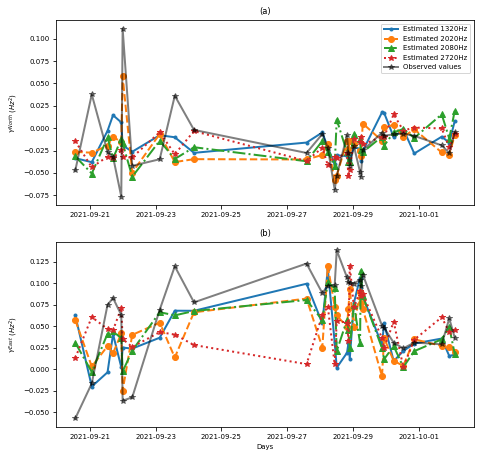

In [60]:
from matplotlib.pyplot import figure
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

plt.rcParams.update({'font.size': 7})
cm = 1/2.54  # centimeters in inches
# [fig, ax] = plt.subplots(2,1, figsize=(19*cm, 19*cm))
[fig, ax] = plt.subplots(2,1, figsize=(19*cm, 19*cm))
style_list=['-','--','-.',':'] # list of basic linestyles
marker_list=['.','o', '^', '*']

def mike_style_plot(model, ax_, Xs,Y, target='Y_x' , title="", folds=5, _func=None): 
    # fig = matplotlib.pyplot.gcf()
    # fig.set_size_inches(19*cm, 19*cm)
    if _func is None: _func = lambda x: x
    ax_.set_title(title)
    arr = {}
    for (freq, X), style, marker in zip(Xs.items(),style_list,marker_list  ):
        X_train, X_test, y_train, y_test = train_test_split(X, Y[target], test_size=0.1, random_state=108)
        model.fit(X_train, y_train, verbose=True)
        y_test_pred = model.predict(X_test)
        xx, yy, yy_pred = zip(*(sorted(zip(X_test.index, y_test, y_test_pred) ) ))
        ax_.plot(xx, _func(yy_pred),  linewidth=2, linestyle = style, marker=marker, label = f'Estimated {freq}')
        cv_results = cross_validate(model, X, Y[target], scoring='neg_root_mean_squared_error', cv=folds)
        print(f"{target}| {freq} Hz, {folds} folds. RMSE mean: {-np.mean(cv_results['test_score']) }, std: {np.std(cv_results['test_score'])}, mean%:  {100.*-np.mean(cv_results['test_score']) / Y[target].std()}, std%:  {100.*np.std(cv_results['test_score']) / Y[target].std()}" ) 
        print(f"{target}| {freq} Hz, {folds} folds. RMSPE mean: {rmspe(np.array(yy), np.array(yy_pred) )}%" ) 
    
    # plot true values curve
    ax_.plot(xx, _func(yy),  alpha=0.5, linewidth=2, color='black', label = 'Observed values', marker='*')
    
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 30, max_depth=3)
    
mike_style_plot(model, ax[0], Xs, Y, 'Y_x', '(a)')

ax[0].set_ylabel('$ Y^{North} \; (Hz^2) $')
ax[0].legend()
mike_style_plot(model, ax[1], Xs, Y, 'Y_y', '(b)')
ax[1].set_ylabel('$ Y^{East} \; (Hz^2) $')
ax[1].set_xlabel('Days')


# fig.savefig('_north_east_freq_preds_mikestyle.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight') 

Hm0| 1320Hz Hz, 5 folds. RMSE mean: 47.3277715852317, std: 22.677148808650255, mean%:  80.32595283046925, std%:  38.488260159317925
Hm0| 1320Hz Hz, 5 folds. RMSPE mean: 116.0848049660487%
Hm0| 2020Hz Hz, 5 folds. RMSE mean: 39.32081417815694, std: 19.738131131153423, mean%:  66.73633173795706, std%:  33.500081180610366
Hm0| 2020Hz Hz, 5 folds. RMSPE mean: 45.749852869069706%
Hm0| 2080Hz Hz, 5 folds. RMSE mean: 41.723507285136364, std: 16.634390218368257, mean%:  70.81424638960625, std%:  28.232329545412426
Hm0| 2080Hz Hz, 5 folds. RMSPE mean: 102.4846837623383%
Hm0| 2720Hz Hz, 5 folds. RMSE mean: 35.27929292204077, std: 19.425063144897074, mean%:  59.876954359550595, std%:  32.968733866877876
Hm0| 2720Hz Hz, 5 folds. RMSPE mean: 57.33922799275475%
waves_power| 1320Hz Hz, 5 folds. RMSE mean: 0.028166105741734216, std: 0.006430357585530038, mean%:  93.87870214380825, std%:  21.432626504546512
waves_power| 1320Hz Hz, 5 folds. RMSPE mean: 32.627681830509026%
waves_power| 2020Hz Hz, 5 folds

Text(0.5, 0, 'Days')

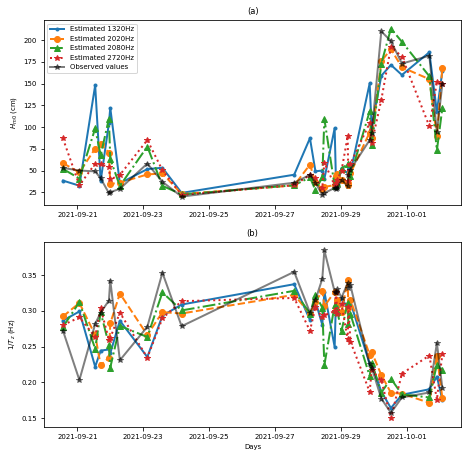

In [19]:
[fig, ax] = plt.subplots(2,1, figsize=(19*cm, 19*cm))
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 30, max_depth=3)
mike_style_plot(model, ax[0], Xs, Y, 'Hm0', '(a)')
ax[0].set_ylabel('$H_{m0}$ (cm)')
ax[0].legend()
mike_style_plot(model, ax[1], Xs, Y, 'waves_power', '(b)', _func=np.sqrt)
ax[1].set_ylabel('$1/T_z$ (Hz)')
ax[1].set_xlabel('Days')

## Wave direction classification

**work with 2720Hz**

In [34]:
dirp_classes = []
for index, row in Y.iterrows():
    if row['Dirp'] <= 90.0:
        dirp_classes.append(0)
    elif row['Dirp'] <= 180.0:
        dirp_classes.append(1)
    elif row['Dirp'] <= 270.0:
        dirp_classes.append(2)
    else:
        dirp_classes.append(3)

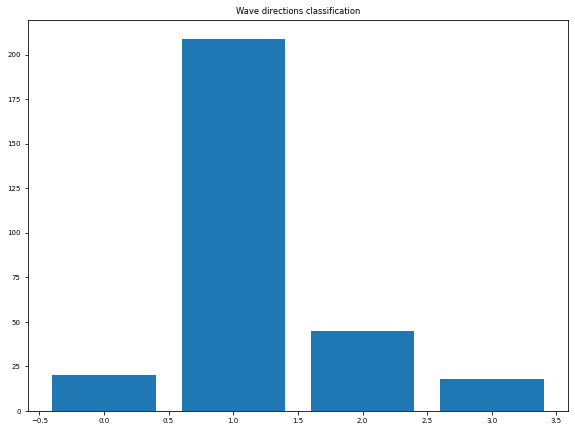

In [74]:
from collections import Counter
dirp_classes_dict = Counter(dirp_classes)

keys = dirp_classes_dict.keys()
values = dirp_classes_dict.values()

fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(keys, values)
plt.title('Wave directions classification')
plt.show()

In [35]:
Y['Dirp_class'] = dirp_classes

In [37]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [38]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
random_forest = RandomForestClassifier(n_estimators=10, max_depth=7, random_state=17)
scores = cross_val_score(random_forest, Xs['2720Hz'], Y['Dirp_class'], scoring='accuracy', cv=kfold, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.726 (0.059)


In [39]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gbc = GradientBoostingClassifier(n_estimators=10, max_depth=7, random_state=0)
scores = cross_val_score(gbc, Xs['2720Hz'], Y['Dirp_class'], scoring='accuracy', cv=kfold, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.706 (0.072)


**Parameters optimization**

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
param_grid = {
    'max_depth': [5, 7, 9, 11],
    'n_estimators': [10, 20, 40, 50],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf' : [1, 2, 3]
}

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
random_forest = RandomForestClassifier()
grid_search = GridSearchCV(random_forest, param_grid, cv=kfold)
grid_search.fit(Xs['2720Hz'], Y['Dirp_class'])

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 7, 9, 11],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 20, 40, 50]})

In [44]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_split=4, n_estimators=20)

In [45]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
random_forest = RandomForestClassifier(max_depth=9,
                                       min_samples_split=4,
                                       n_estimators=20,
                                       random_state=17)
scores = cross_val_score(random_forest, Xs['2720Hz'], Y['Dirp_class'], scoring='accuracy', cv=kfold, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.733 (0.075)


In [64]:
from sklearn.metrics import plot_confusion_matrix

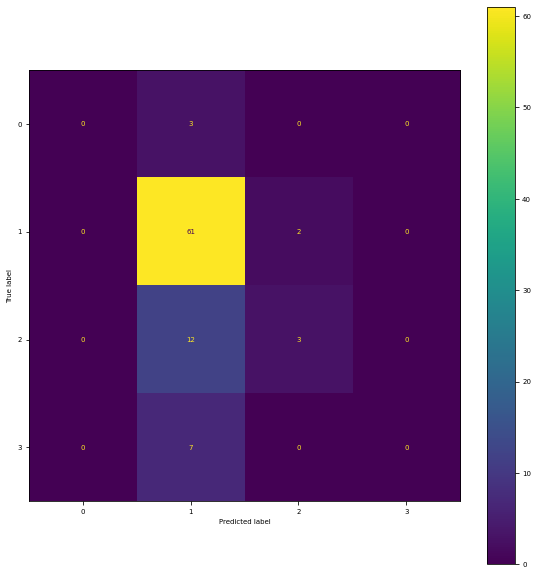

In [76]:
X_train, X_test, y_train, y_test = train_test_split(Xs['2720Hz'], Y['Dirp_class'], test_size=0.3, random_state=108)
model = RandomForestClassifier(max_depth=9,
                               min_samples_split=4,
                               n_estimators=20,
                               random_state=17)
model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(model, X_test, y_test, ax=ax)
plt.show()

## Wave direction Regression 

Dirp| 1320Hz Hz, 5 folds. RMSE mean: 81.01558582533713, std: 16.416558671855753, mean%:  124.06089856214248, std%:  25.139027254822444
Dirp| 1320Hz Hz, 5 folds. RMSPE mean: 43.212621411700816%
Dirp| 2020Hz Hz, 5 folds. RMSE mean: 81.81794894088209, std: 11.706452952513184, mean%:  125.28957435425774, std%:  17.926341672024662
Dirp| 2020Hz Hz, 5 folds. RMSPE mean: 45.11606124258137%
Dirp| 2080Hz Hz, 5 folds. RMSE mean: 82.1703408016668, std: 14.21368869480492, mean%:  125.82919954426978, std%:  21.765725365014685
Dirp| 2080Hz Hz, 5 folds. RMSPE mean: 36.86981606578212%
Dirp| 2720Hz Hz, 5 folds. RMSE mean: 78.12596037233652, std: 11.476628609425498, mean%:  119.63595333024392, std%:  17.574406742165824
Dirp| 2720Hz Hz, 5 folds. RMSPE mean: 41.379122286296%


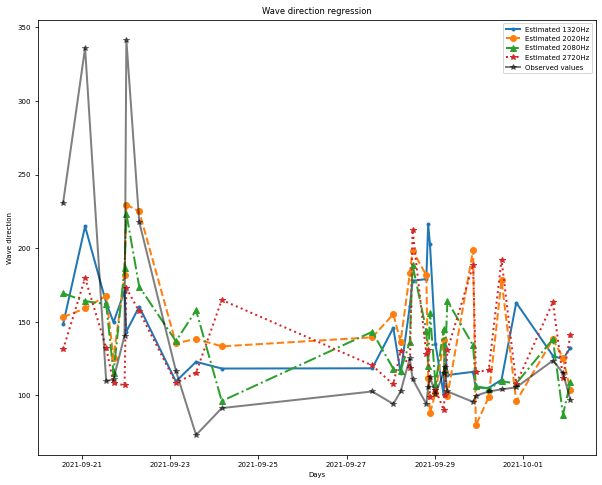

In [61]:
plt.rcParams.update({'font.size': 7})
cm = 1/2.54  # centimeters in inches
# [fig, ax] = plt.subplots(2,1, figsize=(19*cm, 19*cm))
style_list=['-','--','-.',':'] # list of basic linestyles
marker_list=['.','o', '^', '*']

def mike_style_plot(model, Xs, Y, target='Dirp', title="", folds=5, _func=None): 
    # fig = matplotlib.pyplot.gcf()
    # fig.set_size_inches(19*cm, 19*cm)
    fig = plt.figure(figsize=(10, 8))
    if _func is None: _func = lambda x: x
    plt.title(title)
    arr = {}
    for (freq, X), style, marker in zip(Xs.items(),style_list,marker_list  ):
        X_train, X_test, y_train, y_test = train_test_split(X, Y[target], test_size=0.1, random_state=108)
        model.fit(X_train, y_train, verbose=True)
        y_test_pred = model.predict(X_test)
        xx, yy, yy_pred = zip(*(sorted(zip(X_test.index, y_test, y_test_pred) ) ))
        plt.plot(xx, _func(yy_pred),  linewidth=2, linestyle = style, marker=marker, label = f'Estimated {freq}')
        cv_results = cross_validate(model, X, Y[target], scoring='neg_root_mean_squared_error', cv=folds)
        print(f"{target}| {freq} Hz, {folds} folds. RMSE mean: {-np.mean(cv_results['test_score']) }, std: {np.std(cv_results['test_score'])}, mean%:  {100.*-np.mean(cv_results['test_score']) / Y[target].std()}, std%:  {100.*np.std(cv_results['test_score']) / Y[target].std()}" ) 
        print(f"{target}| {freq} Hz, {folds} folds. RMSPE mean: {rmspe(np.array(yy), np.array(yy_pred) )}%" ) 
    
    # plot true values curve
    plt.plot(xx, _func(yy),  alpha=0.5, linewidth=2, color='black', label = 'Observed values', marker='*')
    plt.ylabel('Wave direction')
    plt.xlabel('Days')
    plt.legend()

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 30, max_depth=3)
    
mike_style_plot(model, Xs, Y, 'Dirp', 'Wave direction regression')


